<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

**CONTESTO:** Rock o Hip-Hop? Applica metodi di machine learning per classificare i brani in generi musicali, senza doverli ascoltare :) 

**OBIETTIVO:** 

Utilizzando un set di dati composto da brani di due generi musicali (Hip-Hop e Rock), addestrerai un classificatore per distinguere tra i due generi in base solo alle informazioni sui brani derivate dai dati che hai a disposizione. Per prima cosa utilizzerai Pandas per analizzare i dati, aggregare informazioni e creare grafici con Seaborn o MatplotLib.

Successivamente, utilizzerai la libreria scikit-learn per prevedere se puoi classificare correttamente il genere di una canzone in base a caratteristiche come energia, acustica, tempo, ballabilità etc..


**Dati a disposizione:**

Qui puoi trovare due fonti dati, uno in formato csv e l'altro in formato json.

https://drive.google.com/drive/folders/1vPd0qBCpWm_QEXM5NRynNrs72-pUuhSn?usp=sharing

In [12]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_rows', 2536)
pd.set_option('display.max_columns', 100)

In [2]:
# Loading of the dataset
df = pd.read_csv("./Dati/dataset.csv")
metrics = pd.read_json('./Dati/metrics.json', precise_float=True)

# Merge the dataframes
df_all = pd.merge(df[['track_id', 'genre_top']], metrics, on='track_id')

## Data cleaning

In [3]:
df_all.columns

Index(['track_id', 'genre_top', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')

Plot dei valori nulli

<Axes: >

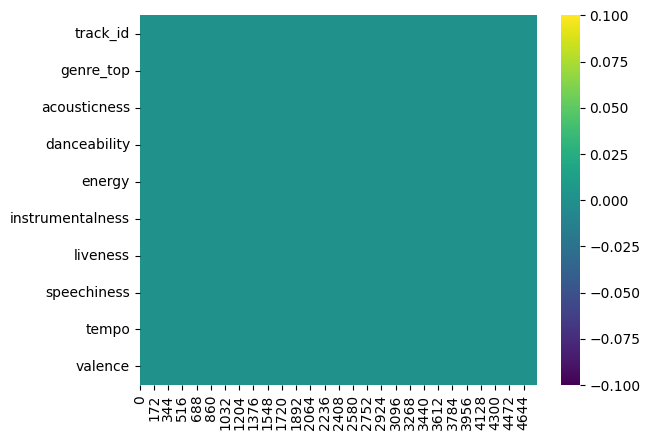

In [4]:
sns.heatmap(df_all.transpose().isnull(), cmap='viridis')

Analizzo le tipologie di dato

In [5]:
df_all.drop('track_id', inplace=True, axis=1)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre_top         4802 non-null   object 
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
dtypes: float64(8), object(1)
memory usage: 504.2+ KB


## Exploratory data analysis

In [6]:
df_all.head()

,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632
2,Rock,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325
3,Rock,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347
4,Rock,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548


In [7]:
df_grouped = df_all.groupby('genre_top').mean().reset_index()
df_melted = pd.melt(df_grouped, id_vars='genre_top', value_vars=['acousticness', 'danceability', 'energy', 
                                                      'instrumentalness','liveness', 'speechiness', 
                                                      'tempo', 'valence'], var_name='feature', value_name='value')

<Axes: xlabel='feature', ylabel='value'>

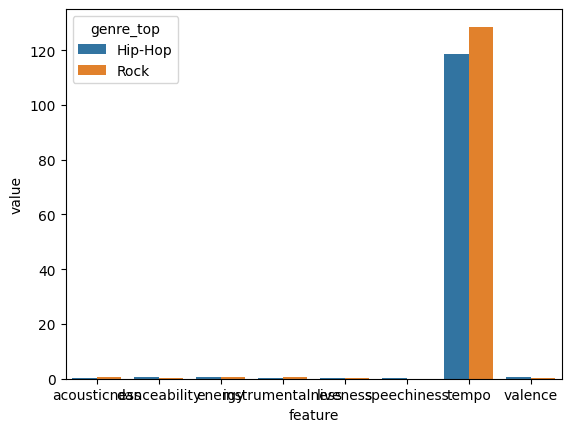

In [8]:
sns.barplot(x='feature', y='value', hue='genre_top', data=df_melted)

## Predictive model

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_all.loc[:, 'acousticness':], df_all.genre_top, test_size = 0.2, random_state=42)

In [80]:
def dict_to_df(dic):
    df = pd.DataFrame(columns=['type', 'function', 'depth', 'precision', 'recall', 'f1-score', 'support'])

    for f in dic.keys():
        for depth in dic[f].keys():
            for 

In [81]:
dict_to_df(dict())

true


In [74]:
results = {}

tree = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_split=2)

for f in ['entropy', 'gini', 'log_loss']:
    results[f] = dict()

    for depth in range(2, 20):
        tree = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_split=2)
        tree = tree.fit(X_train, y_train)

        y_test_pred  = tree.predict(X_test)
        y_train_pred = tree.predict(X_train)

        results[f][depth] = metrics.classification_report(y_test, y_test_pred, output_dict=True)

In [75]:
results

{'entropy': {2: {'Hip-Hop': {'precision': 0.7784810126582279,
    'recall': 0.6910112359550562,
    'f1-score': 0.7321428571428573,
    'support': 178},
   'Rock': {'precision': 0.9315068493150684,
    'recall': 0.9553001277139208,
    'f1-score': 0.9432534678436317,
    'support': 783},
   'accuracy': 0.9063475546305931,
   'macro avg': {'precision': 0.8549939309866481,
    'recall': 0.8231556818344885,
    'f1-score': 0.8376981624932445,
    'support': 961},
   'weighted avg': {'precision': 0.9031628337844569,
    'recall': 0.9063475546305931,
    'f1-score': 0.9041507740821979,
    'support': 961}},
  3: {'Hip-Hop': {'precision': 0.7784810126582279,
    'recall': 0.6910112359550562,
    'f1-score': 0.7321428571428573,
    'support': 178},
   'Rock': {'precision': 0.9315068493150684,
    'recall': 0.9553001277139208,
    'f1-score': 0.9432534678436317,
    'support': 783},
   'accuracy': 0.9063475546305931,
   'macro avg': {'precision': 0.8549939309866481,
    'recall': 0.82315568183

In [73]:
results_df = pd.json_normalize(results)
results_df.head()

,entropy.2,entropy.3,entropy.4,entropy.5,entropy.6,entropy.7,entropy.8,entropy.9,entropy.10,entropy.11,entropy.12,entropy.13,entropy.14,entropy.15,entropy.16,entropy.17,entropy.18,entropy.19,gini.2,gini.3,gini.4,gini.5,gini.6,gini.7,gini.8,gini.9,gini.10,gini.11,gini.12,gini.13,gini.14,gini.15,gini.16,gini.17,gini.18,gini.19,log_loss.2,log_loss.3,log_loss.4,log_loss.5,log_loss.6,log_loss.7,log_loss.8,log_loss.9,log_loss.10,log_loss.11,log_loss.12,log_loss.13,log_loss.14,log_loss.15,log_loss.16,log_loss.17,log_loss.18,log_loss.19
0,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...


### Model performance without scaling

In [32]:
tree = tree.fit(X_train, y_train)

y_test_pred  = tree.predict(X_test)
y_train_pred = tree.predict(X_train)

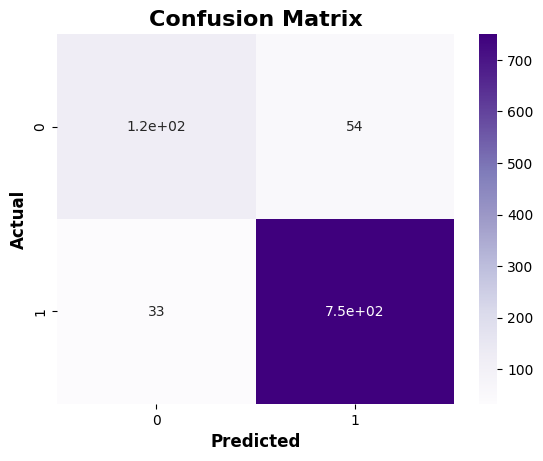

In [33]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Purples')
plt.title('Confusion Matrix', fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold', fontsize=12)
plt.show();

In [34]:
print('Accuracy - Test Set: ',  metrics.accuracy_score(y_test, y_test_pred))
print('Accuracy - Train Set: ', metrics.accuracy_score(y_train, y_train_pred))

Accuracy - Test Set:  0.9094693028095734
Accuracy - Train Set:  0.9268419682374381


In [35]:
print('Report on test set \n', metrics.classification_report(y_test, y_test_pred))
print('Report on train set\n', metrics.classification_report(y_train, y_train_pred))

Report on test set 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.70      0.74       178
        Rock       0.93      0.96      0.95       783

    accuracy                           0.91       961
   macro avg       0.86      0.83      0.84       961
weighted avg       0.91      0.91      0.91       961

Report on train set
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.77      0.80       732
        Rock       0.95      0.96      0.96      3109

    accuracy                           0.93      3841
   macro avg       0.89      0.87      0.88      3841
weighted avg       0.93      0.93      0.93      3841



### Model performance with scaling

In [36]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
X_train = MinMaxScaler().fit_transform(X_train)
X_test  = MinMaxScaler().fit_transform(X_test)

In [58]:
tree = tree.fit(X_train, y_train)

y_test_pred  = tree.predict(X_test)
y_train_pred = tree.predict(X_train)

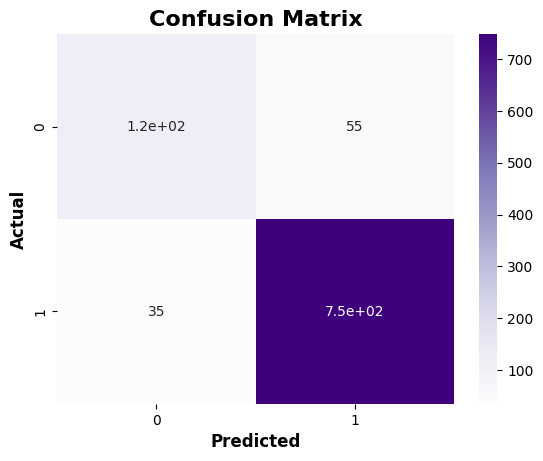

In [59]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Purples')
plt.title('Confusion Matrix', fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold', fontsize=12)
plt.show();

In [49]:
print('Accuracy - Test Set: ',  metrics.accuracy_score(y_test, y_test_pred))
print('Accuracy - Train Set: ', metrics.accuracy_score(y_train, y_train_pred))

Accuracy - Test Set:  0.9073881373569199
Accuracy - Train Set:  0.9177297578755532


In [50]:
print('Report on test set \n', metrics.classification_report(y_test, y_test_pred))
print('Report on train set\n', metrics.classification_report(y_train, y_train_pred))

Report on test set 
               precision    recall  f1-score   support

     Hip-Hop       0.76      0.73      0.74       178
        Rock       0.94      0.95      0.94       783

    accuracy                           0.91       961
   macro avg       0.85      0.84      0.84       961
weighted avg       0.91      0.91      0.91       961

Report on train set
               precision    recall  f1-score   support

     Hip-Hop       0.78      0.80      0.79       732
        Rock       0.95      0.95      0.95      3109

    accuracy                           0.92      3841
   macro avg       0.86      0.87      0.87      3841
weighted avg       0.92      0.92      0.92      3841

